# PyMC3-Monty-Hall - Rochford

Author: Austin Rochford

http://austinrochford.com/resources/talks/pp-pymc3-odsc-east-2017.slides.html#/
https://gist.github.com/AustinRochford/9589e6ec6649954e09bda5e7641f75d4 

A Dockerfile that will produce a container with all the dependencies necessary to run this notebook is available [here](https://github.com/AustinRochford/notebooks).

In [1]:
!pip install pymc3

pyasn1-modules 0.2.1 has requirement pyasn1<0.5.0,>=0.4.1, but you'll have pyasn1 0.1.9 which is incompatible.
grpcio 1.11.0 has requirement protobuf>=3.5.0.post1, but you'll have protobuf 3.4.1 which is incompatible.


In [2]:
%matplotlib inline

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [3]:
import datetime
import logging
from warnings import filterwarnings

In [4]:
from matplotlib import pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from theano import pprint

In [5]:
sns.set(color_codes=True)
pct_formatter = StrMethodFormatter('{x:.1%}')

In [6]:
# configure pyplot for readability when rendered as a slideshow and projected
FIG_WIDTH, FIG_HEIGHT = 8, 6
plt.rc('figure', figsize=(FIG_WIDTH, FIG_HEIGHT))

LABELSIZE = 14
plt.rc('axes', labelsize=LABELSIZE)
plt.rc('axes', titlesize=LABELSIZE)
plt.rc('figure', titlesize=LABELSIZE)
plt.rc('legend', fontsize=LABELSIZE)
plt.rc('xtick', labelsize=LABELSIZE)
plt.rc('ytick', labelsize=LABELSIZE)

In [7]:
filterwarnings('ignore', 'findfont')
filterwarnings('ignore', "Conversion of the second argument of issubdtype")
filterwarnings('ignore', "Set changed size during iteration")

# keep theano from complaining about compile locks for small models
(logging.getLogger('theano.gof.compilelock')
        .setLevel(logging.CRITICAL))

In [8]:
SEED = 54902 # from random.org, for reproducibility

np.random.seed(SEED)

# The HMC Revolution is Open Source
## Probabilistic Programming with PyMC3

<center><img src='https://raw.githubusercontent.com/pymc-devs/pymc3/master/docs/pymc3_logo.jpg'></center>

## [@AustinRochford](https://twitter.com/AustinRochford) &#8226; [#ODSC](https://odsc.com/) East &#8226; Boston &#8226; May 3, 2018

## Who am I?

<center><img src='http://austinrochford.com/resources/img/face_big.png' width=400></center>

### PyMC3 developer &#8226; Principal Data Scientist and Director of [Monetate Labs](http://www.monetate.com/)

### [@AustinRochford](https://twitter.com/AustinRochford) &#8226; [Website](austinrochford.com) &#8226; [GitHub](https://github.com/AustinRochford/)

### [arochford@monetate.com](mailto:arochford@monetate.com) &#8226; [austin.rochford@gmail.com](mailto:austin.rochford@gmail.com)

## About This Talk

<center>
    <script src="https://gist.github.com/AustinRochford/ab807b6d3ca64e903f911f3dd33a7044.js"></script>
</center>

## About Monetate

<center><img src='http://austinrochford.com/resources/talks/img/monetate_logos.png' width=700></center>

* Founded 2008, web optimization and personalization SaaS
* Observed 5B impressions and $4.1B in revenue during Cyber Week 2017

<center>
    <img src='https://technical.ly/philly/wp-content/uploads/sites/2/2014/10/monetate-sign.jpg' width=700>
    <a href="https://www.monetate.com/about/careers">monetate.com/about/careers</a>
</center>

## Modern Bayesian Inference

<center><img src="https://upload.wikimedia.org/wikipedia/commons/1/18/Bayes%27_Theorem_MMB_01.jpg" width=800></center>

### MCMC Revolution (Diaconis)

<center>
    <iframe src="https://www.ams.org/journals/bull/2009-46-02/S0273-0979-08-01238-X/" width=800 height=600></iframe>
</center>

[_The Markov Chain Monte Carlo Revolution_](https://math.uchicago.edu/~shmuel/Network-course-readings/MCMCRev.pdf) by famous probabilist [Persi Diaconis](https://en.wikipedia.org/wiki/Persi_Diaconis) gives an excellent overview of applications of simulation to many quantitative problems.

### Motivating Examples

####  2017 UK General Election

<center>
<table>
    <tr>
        <td><img src="https://upload.wikimedia.org/wikipedia/en/thumb/a/ae/Flag_of_the_United_Kingdom.svg/1280px-Flag_of_the_United_Kingdom.svg.png" width=300></td>
        <td><img src="https://upload.wikimedia.org/wikipedia/commons/d/d3/Official_portrait_of_Jeremy_Corbyn_crop_2.jpg" width=200></td>
        <td><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5c/Theresa_May.png/220px-Theresa_May.png"></td>
    </tr>
</table>
</center>

[YouGov](https://today.yougov.com/), a polling and opinion data company, correctly called a hung parilment as a result of the 2017 UK general elections in the UK using a Bayesian opinion modeling technique knowns as [multilevel regression with poststratification (MRP)](http://austinrochford.com/posts/2017-07-09-mrpymc3.html) to produce accurate estimates of voter preferences in the UK's 650 parliamentary constituences.

<center>
    <img src="http://austinrochford.com/resources/talks/img/times_yougov.png" width=700>
</center>

<center>
    <img src="https://d18lkz4dllo6v2.cloudfront.net/cumulus_uploads/entry/18266/yougov-model-uk-2017-general-electio-banner.jpg?w=660">
    <a href="https://yougov.co.uk/news/2017/05/31/how-yougov-model-2017-general-election-works/">Source</a>
</center>

#### NBA Foul Calls

<center>
    <img src="https://upload.wikimedia.org/wikipedia/commons/7/76/Kyrie_Irving_Free_Throw.jpg" width=700>
    <a href="http://austinrochford.com/posts/2018-02-04-nba-irt-2.html">Source</a>
</center>

I have done [some work](http://austinrochford.com/posts/2018-02-04-nba-irt-2.html) using Bayesian methods to study whether or not committing/drawing fouls is a measurable skill among NBA players.

##### Player skills(?)

<center>
    <img src="http://austinrochford.com/resources/nba_irt2/An%20Improved%20Analysis%20of%20NBA%20Foul%20Calls%20with%20Python_157_0.png">
</center>

<center>
<table>
    <tr>
        <td><img src="http://austinrochford.com/resources/nba_irt2/An%20Improved%20Analysis%20of%20NBA%20Foul%20Calls%20with%20Python_161_0.png"></td>
        <td><img src="http://austinrochford.com/resources/nba_irt2/An%20Improved%20Analysis%20of%20NBA%20Foul%20Calls%20with%20Python_163_0.png"></td>
    </tr>
</table>
</center>    

## Probabilistic Programming

### Data Science &mdash; inference enables storytelling

<center><img src="https://www.edwardtufte.com/tufte/graphics/minard_lg.gif" width="800">

### Probabilistic Programming &mdash; storytelling enables inference

<center><img src="http://austinrochford.com/resources/talks/img/prob_prog_png.png" width=800></center>

### The Monty Hall Problem

<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/3/3f/Monty_open_door.svg/640px-Monty_open_door.svg.png'></center>

Initially, we have no information about which door the prize is behind.

In [9]:
import pymc3 as pm

with pm.Model() as monty_model:
    prize = pm.DiscreteUniform('prize', 0, 2)

If we choose door one:

<table>
    <tr>
        <td></td>
        <th colspan="3"><center>Monty can open</center></th>
    </tr>
    <tr>
        <th>Prize behind</th>
        <td>Door 1</td>
        <td>Door 2</td>
        <td>Door 3</td>
    </tr>
    <tr>
        <td>Door 1</td>
        <td><font color="red">No</font></td>
        <td><font color="green">Yes</font></td>
        <td><font color="green">Yes</font></td>
    </tr>
    <tr>
        <td>Door 2</td>
        <td><font color="red">No</font></td>
        <td><font color="red">No</font></td>
        <td><font color="green">Yes</font></td>
    </tr>
    <tr>
        <td>Door 2</td>
        <td><font color="red">No</font></td>
        <td><font color="green">Yes</font></td>
        <td><font color="red">No</font></td>
    </tr>
</table>

In [10]:
from theano import tensor as tt

with monty_model:
    p_open = pm.Deterministic(
        'p_open',
        tt.switch(tt.eq(prize, 0),
            np.array([0., 0.5, 0.5]), # it is behind the first door
        tt.switch(tt.eq(prize, 1),
            np.array([0., 0., 1.]),   # it is behind the second door
            np.array([0., 1., 0.])))  # it is behind the third door
    )

Monty opened the third door, revealing a goat.

<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/3/3f/Monty_open_door.svg/640px-Monty_open_door.svg.png' width='500'></center>

In [11]:
with monty_model:
    opened = pm.Categorical('opened', p_open, observed=2)

Should we switch our choice of door?

In [12]:
NJOB = 4

SAMPLE_KWARGS = {
    'njob': NJOB,
    'random_seed': list(SEED + np.arange(NJOB))
}

In [13]:
MONTY_SAMPLE_KWARGS = {
    'init': None,
    'compute_convergence_checks': False,
    **SAMPLE_KWARGS
}

In [14]:
with monty_model:
    monty_trace = pm.sample(1000, **MONTY_SAMPLE_KWARGS)
    
monty_df = pm.trace_to_dataframe(monty_trace)

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [prize]
100%|██████████| 1500/1500 [00:04<00:00, 361.56it/s]


In [15]:
monty_df['prize'].head()

0    0
1    0
2    0
3    0
4    1
Name: prize, dtype: int64

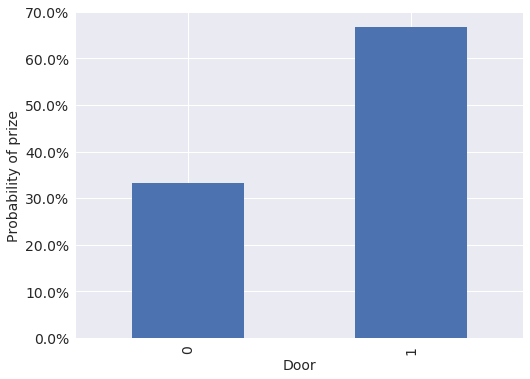

In [16]:
ax = (monty_df['prize']
              .value_counts(normalize=True, ascending=True)
              .plot(kind='bar', color='b'))

ax.set_xlabel("Door");
ax.yaxis.set_major_formatter(pct_formatter);
ax.set_ylabel("Probability of prize");

#### Probabilistic programming is not new

<center>
    <table>
        <tr>
            <td>
                <img src="https://upload.wikimedia.org/wikipedia/en/e/e6/BUGS_logo.gif" width=200>
            </td>
            <td>
                <img src="https://upload.wikimedia.org/wikipedia/commons/1/18/Bayes%27_Theorem_MMB_01.jpg" width=350>
            </td>
        </tr>
        <tr>
            <td>
                <center><a href="https://www.mrc-bsu.cam.ac.uk/software/bugs/">BUGS</a> (1989)</center>
            </td>
            <td>
                <center><a href="http://mcmc-jags.sourceforge.net/">JAGS</a> (2007)</center>
            </td>
        </tr>
    </table>
</center>

<center><img src='https://raw.githubusercontent.com/pymc-devs/pymc3/master/docs/pymc3_logo.jpg'></center>

From the [PyMC3 documentation](http://pymc-devs.github.io/pymc3/):

> PyMC3 is a Python package for Bayesian statistical modeling and Probabilistic Machine Learning which focuses on **advanced Markov chain Monte Carlo** and variational fitting algorithms. Its flexibility and extensibility make it applicable to a large suite of problems.

[![License](https://img.shields.io/badge/License-Apache%202.0-blue.svg)](https://opensource.org/licenses/Apache-2.0)

### Monte Carlo Methods

In [17]:
N = 5000

x, y = np.random.uniform(0, 1, size=(2, N))

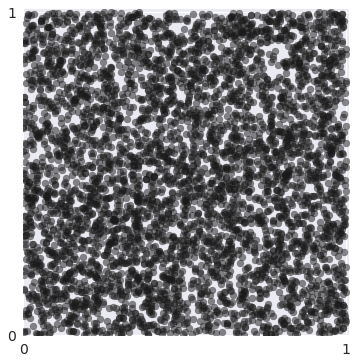

In [18]:
fig, ax = plt.subplots()
ax.set_aspect('equal');

ax.scatter(x, y, c='k', alpha=0.5);

ax.set_xticks([0, 1]);
ax.set_xlim(0, 1.01);

ax.set_yticks([0, 1]);
ax.set_ylim(0, 1.01);

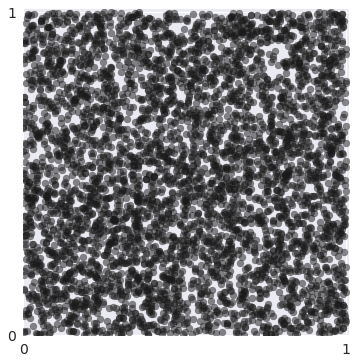

In [19]:
fig

In [20]:
in_circle = x**2 + y**2 <= 1

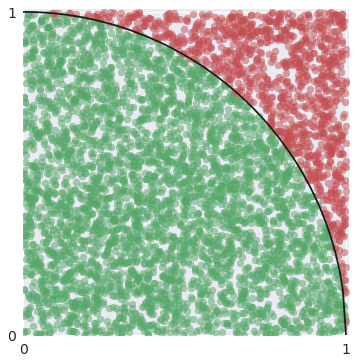

In [21]:
fig, ax = plt.subplots()
ax.set_aspect('equal');

x_plot = np.linspace(0, 1, 100)
ax.plot(x_plot, np.sqrt(1 - x_plot**2), c='k');

ax.scatter(x[in_circle], y[in_circle], c='g', alpha=0.5);
ax.scatter(x[~in_circle], y[~in_circle], c='r', alpha=0.5);

ax.set_xticks([0, 1]);
ax.set_xlim(0, 1.01);

ax.set_yticks([0, 1]);
ax.set_ylim(0, 1.01);

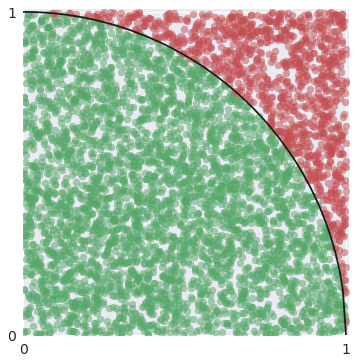

In [22]:
fig

In [23]:
4 * in_circle.mean()

3.1336

#### History of Monte Carlo Methods

<center><img src="http://www.bgu.ac.il/~oaharon/feynman/Feynman_Portraits_files/Ulam_Feynman_von_Neumann.jpg"></center>

## Case Study: NBA Foul Calls

<center><img src="https://upload.wikimedia.org/wikipedia/commons/7/76/Kyrie_Irving_Free_Throw.jpg" width=700></center>

**Question:** Is (not) committing and/or drawing fouls a measurable player skill?

See this [talk](http://austinrochford.com/resources/talks/nba-fouls-pydata-nyc-2017.slides.html) or this [post](http://austinrochford.com/posts/2018-02-04-nba-irt-2.html) for more information on the data, expanded models, and conclusions from this case study.

In [24]:
%%bash
DATA_URI=https://raw.githubusercontent.com/polygraph-cool/last-two-minute-report/32f1c43dfa06c2e7652cc51ea65758007f2a1a01/output/all_games.csv
DATA_DEST=/tmp/all_games.csv

if [[ ! -e $DATA_DEST ]];
then
    wget -q -O $DATA_DEST $DATA_URI
fi

In [25]:
USECOLS = [
    'period',
    'seconds_left',
    'call_type',
    'committing_player',
    'disadvantaged_player',
    'review_decision',
    'play_id',
    'away',
    'home',
    'date',
    'score_away',
    'score_home',
    'disadvantaged_team',
    'committing_team'
]

In [26]:
orig_df = pd.read_csv(
    '/tmp/all_games.csv',
    usecols=USECOLS,
    index_col='play_id',
    parse_dates=['date']
)

In [27]:
orig_df.head(n=2).T

play_id,20150301CLEHOU-0,20150301CLEHOU-1
period,Q4,Q4
seconds_left,112,103
call_type,Foul: Shooting,Foul: Shooting
committing_player,Josh Smith,J.R. Smith
disadvantaged_player,Kevin Love,James Harden
review_decision,CNC,CC
away,CLE,CLE
home,HOU,HOU
date,2015-03-01 00:00:00,2015-03-01 00:00:00
score_away,103,103


In [28]:
foul_df = orig_df[
    orig_df.call_type
           .fillna("UNKNOWN")
           .str.startswith("Foul")
]

In [29]:
FOULS = [
    f"Foul: {foul_type}"
    for foul_type in [
        "Personal",
        "Shooting",
        "Offensive",
        "Loose Ball",
        "Away from Play"
    ]
]

SyntaxError: invalid syntax (<ipython-input-29-2bc829cd96a7>, line 2)

In [ ]:
TEAM_MAP = {
    "NKY": "NYK",
    "COS": "BOS",
    "SAT": "SAS",
    "CHi": "CHI",
    "LA)": "LAC",
    "AT)": "ATL",
    "ARL": "ATL"
}

def correct_team_name(col):
    def _correct_team_name(df):
        return df[col].apply(lambda team_name: TEAM_MAP.get(team_name, team_name))
    
    return _correct_team_name

In [ ]:
def date_to_season(date):
    if date >= datetime.datetime(2017, 10, 17):
        return '2017-2018'
    elif date >= datetime.datetime(2016, 10, 25):
        return '2016-2017'
    elif date >= datetime.datetime(2015, 10, 27):
        return '2015-2016'
    else:
        return '2014-2015'

In [ ]:
clean_df = (foul_df.where(lambda df: df.period == "Q4")
                   .where(lambda df: (df.date.between(datetime.datetime(2016, 10, 25),
                                                      datetime.datetime(2017, 4, 12))
                                      | df.date.between(datetime.datetime(2015, 10, 27),
                                                       datetime.datetime(2016, 5, 30)))
                         )
                   .assign(
                       review_decision=lambda df: df.review_decision.fillna("INC"),
                       committing_team=correct_team_name('committing_team'),
                       disadvantged_team=correct_team_name('disadvantaged_team'),
                       away=correct_team_name('away'),
                       home=correct_team_name('home'),
                       season=lambda df: df.date.apply(date_to_season)
                    )
                   .where(lambda df: df.call_type.isin(FOULS))
                   .dropna()
                   .drop('period', axis=1)
                   .assign(call_type=lambda df: (df.call_type
                                                   .str.split(': ', expand=True)  
                                                   .iloc[:, 1])))

In [ ]:
player_enc = LabelEncoder().fit(
    np.concatenate((
        clean_df.committing_player,
        clean_df.disadvantaged_player
    ))
)
n_player = player_enc.classes_.size

season_enc = LabelEncoder().fit(
    clean_df.season
)
n_season = season_enc.classes_.size

In [ ]:
df = (clean_df[['seconds_left']]
              .round(0)
              .assign(
                foul_called=1. * clean_df.review_decision.isin(['CC', 'INC']),
                player_committing=player_enc.transform(clean_df.committing_player),
                player_disadvantaged=player_enc.transform(clean_df.disadvantaged_player),
                score_committing=clean_df.score_home.where(
                    clean_df.committing_team == clean_df.home,
                    clean_df.score_away
                ),
                score_disadvantaged=clean_df.score_home.where(
                    clean_df.disadvantaged_team == clean_df.home,
                    clean_df.score_away
                ),
                season=season_enc.transform(clean_df.season)
              ))

In [ ]:
player_committing = df.player_committing.values
player_disadvantaged = df.player_disadvantaged.values

season = df.season.values

In [ ]:
def hierarchical_normal(name, shape):
    Δ = pm.Normal(f'Δ_{name}', 0., 1., shape=shape)
    σ = pm.HalfNormal(f'σ_{name}', 5.)
    
    return pm.Deterministic(name, Δ * σ)

### Model outline

$$
\textrm{Foul}\
    \sim \textrm{Season factor} + \left(\textrm{Disadvantaged skill} - \textrm{Committing skill}\right)
$$

In [ ]:
with pm.Model() as irt_model:
    β_season = pm.Normal('β_season', 0., 2.5, shape=n_season)
    
    θ = hierarchical_normal('θ', n_player)
    b = hierarchical_normal('b', n_player)

    p = pm.math.sigmoid(
        β_season[season] + θ[player_disadvantaged] - b[player_committing]
    )
    
    obs = pm.Bernoulli(
        'obs', p,
        observed=df['foul_called'].values
    )

In [ ]:
with irt_model:
    start = pm.find_MAP()

#### Metropolis-Hastings Inference

In [ ]:
NJOBS = 4

SAMPLE_KWARGS = {
    'njobs': NJOBS,
    'start': start,
    'random_seed': list(SEED + np.arange(NJOBS))
}

In [ ]:
with irt_model: 
    step = pm.Metropolis()
    met_trace = pm.sample(20000, step=step, **SAMPLE_KWARGS)

<center><img src="https://media.giphy.com/media/IT6kBZ1k5oEeI/giphy.gif"></center>

In [ ]:
met_gr_stats = pm.gelman_rubin(met_trace)
met_θ_worst_ix = met_gr_stats['θ'].argmax()
met_θ_worst = np.concatenate([
    chain_values[np.newaxis, :, met_θ_worst_ix]
        for chain_values in met_trace.get_values('θ', combine=False)
])

In [ ]:
trace_fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(met_θ_worst.T, alpha=0.5);

ax.set_xticklabels([]);
ax.set_xlabel("Sample index");

worst_param_label = r"Sample $\theta_{" + str(met_θ_worst_ix) + "}$"

ax.set_ylabel(worst_param_label);

ax.set_title("Metropolis-Hastings");

In [ ]:
trace_fig

In [ ]:
fig, ax = plt.subplots()

sns.distplot(
    met_trace['θ'][:, met_θ_worst_ix],
    hist=False, ax=ax
);

ax.set_xlabel(worst_param_label);

ax.set_yticklabels([]);
ax.set_ylabel("Posterior density");

In [ ]:
fig

In [ ]:
trace_fig

In [ ]:
max(np.max(var_stats) for var_stats in pm.gelman_rubin(met_trace).values())

### The Curse of Dimensionality

This model has

In [ ]:
n_param = n_season + 2 * n_player
n_param

parameters

The [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality) is a well-known concept in machine learning.  It refers to the fact that as the number of dimensions in the sample space increases, samples become (on average) far apart quite quickly.  It is related to the more complicated phenomenon of [concentration of measure](https://en.wikipedia.org/wiki/Concentration_of_measure), which is the actual motivation for Hamiltonian Monte Carlo (HMC) algorithms.

The following plot illustrates one of the one aspect of the curse of dimensionality, that the volume of the unit ball tends to zero as the dimensionality of the space becomes large.  That is, if

$$
\begin{align*}
S_d
    & = \left\{\left.\vec{x} \in \mathbb{R}^d\ \right|\ x_1^2 + \cdots + x_d^2 \leq 1\right\}, \\
\operatorname{Vol}(S_d)
    & = \frac{2 \pi^{\frac{d}{2}}}{d\ \Gamma\left(\frac{d}{2}\right)}.
\end{align*}$$

And we get that $\operatorname{Vol}(S_d) \to 0$ as $d \to \infty$.

In [ ]:
def sphere_volume(d):
    return 2. * np.power(np.pi, d / 2.) / d / sp.special.gamma(d / 2)

In [ ]:
fig, ax = plt.subplots()

d_plot = np.linspace(1, n_param)

ax.plot(d_plot, sphere_volume(d_plot));

ax.set_xscale('log');
ax.set_xlabel("Dimensions");

ax.set_yscale('log');
ax.set_ylabel("Volume of the unit sphere");

In [ ]:
fig

## Hamiltonian Monte Carlo Inference

### Bayesian inference ⇔ Differential geometry

<center><img src="https://upload.wikimedia.org/wikipedia/commons/6/61/Gaussian_curvature.svg" width="500"></center>

### Automating calculus

<center><img src="http://www.deeplearning.net/software/theano/_static/theano_logo.png"></center>

$$\frac{d}{dx} \left(x^3\right) = 3 x^2$$

In [ ]:
x = tt.dscalar('x')
x.tag.test_value = 0.

y = x**3

In [ ]:
pprint(tt.grad(y, x))

### Case Study Continued: NBA Foul Calls

In [ ]:
with irt_model:
    nuts_trace = pm.sample(500, **SAMPLE_KWARGS)

In [ ]:
nuts_gr_stats = pm.gelman_rubin(nuts_trace)
max(np.max(var_stats) for var_stats in nuts_gr_stats.values())

In [ ]:
nuts_θ_worst = np.concatenate([
    chain_values[np.newaxis, :, met_gr_stats['θ'].argmax()]
        for chain_values in nuts_trace.get_values('θ', combine=False)
])

In [ ]:
fig, (met_ax, nuts_ax) = plt.subplots(ncols=2, sharey=True, figsize=(16, 6))

# metropolis plot
met_ax.plot(met_θ_worst.T, alpha=0.5);

met_ax.set_xticklabels([]);
met_ax.set_xlabel("Sample index");

met_ax.set_ylabel(worst_param_label);

met_ax.set_title("Metropolis-Hastings");

# nuts plot
nuts_ax.plot(nuts_θ_worst.T, alpha=0.5);

nuts_ax.set_xticklabels([]);
nuts_ax.set_xlabel("Sample index");

nuts_ax.set_title("NUTS");

fig.tight_layout();

In [ ]:
fig

In [ ]:
fig, (met_ax, nuts_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(16, 6))

sns.distplot(
    met_trace['θ'][:, met_θ_worst_ix],
    hist=False, ax=met_ax
);

met_ax.set_xlabel(worst_param_label);

met_ax.set_yticklabels([]);
met_ax.set_ylabel("Posterior density");

sns.distplot(
    nuts_trace['θ'][:, met_θ_worst_ix],
    hist=False, ax=nuts_ax
);

nuts_ax.set_xlabel(worst_param_label);

In [ ]:
fig

#### Basketball strategy leads to more complexity

In [ ]:
df['trailing_committing'] = (df.score_committing
                               .lt(df.score_disadvantaged)
                               .mul(1.)
                               .astype(np.int64))

In [ ]:
def make_foul_rate_yaxis(ax, label="Observed foul call rate"):
    ax.yaxis.set_major_formatter(pct_formatter)
    ax.set_ylabel(label)
    
    return ax

In [ ]:
def make_time_axes(ax,
                   xlabel="Seconds remaining in game",
                   ylabel="Observed foul call rate"):
    ax.invert_xaxis()
    ax.set_xlabel(xlabel)
    
    return make_foul_rate_yaxis(ax, label=ylabel)

In [ ]:
fig = make_time_axes(
    df.pivot_table('foul_called', 'seconds_left', 'trailing_committing')
      .rolling(20).mean()
      .rename(columns={0: "No", 1: "Yes"})
      .rename_axis("Committing team is trailing", axis=1)
      .plot()
).figure

In [ ]:
fig

## Next Steps

The following books/GitHub repositories provide good introductions to PyMC3 and Bayesian statistics.

### PyMC3

<table>
    <tr>
        <td>
            <a href="https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers#pymc3"><img src="https://camo.githubusercontent.com/4a0aca82ca82efab71747d00db30f3a68de98e82/687474703a2f2f692e696d6775722e636f6d2f36444b596250622e706e673f31" width="300"></a>
            <br>
        </td>
        <td>
            <a href="https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3"><img src="http://xcelab.net/rm/wp-content/uploads/2012/01/9781482253443.jpg" width="250"></a>
        </td>
        <td>
            <a href="https://www.amazon.com/Bayesian-Analysis-Python-Osvaldo-Martin-ebook/dp/B07CKQZ7V3"><img src="https://images-na.ssl-images-amazon.com/images/I/51ns1HxOPnL._SY346_.jpg" width=275></a>
        </td>
    </tr>
</table>

### Probabilistic Programming Ecosystem

<center>
    <img src="http://austinrochford.com/resources/talks/img/numfocus_pp.png" width=700>
</center>

### Hamiltonian Monte Carlo

<center>
    <iframe src="https://arxiv.org/abs/1701.02434" width=700 height=500></iframe>
</center>

## Thank you!

<center>
    <img src="https://media1.giphy.com/media/xIJLgO6rizUJi/giphy.gif">
</center>

### [@AustinRochford](https://twitter.com/AustinRochford) &#8226; [arochford@monetate.com](mailto:arochford@monetate.com) &#8226; [austin.rochford@gmail.com](mailto:austin.rochford@gmail.com)

In [ ]:
%%bash
jupyter nbconvert \
    --to=slides \
    --reveal-prefix=https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.2.0/ \
    --output=hmc-oss-pymc3-odsc-east-2018 \
    ./HMC\ Open\ Source\ PyMC3.ipynb